<a href="https://colab.research.google.com/github/Gladwin-George/Image-Processing-with-Deep-Neural-Networks/blob/main/Task_2_oxfordiit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2: Image Processing with Deep Neural Networks (DNNs)**



---


---


## **Dataset: OxfordPetsIIIT**

This notebook investigates the use of a pretrained Deep Neural Network (DINOv2) for image representation learning on the Oxford-IIIT Pets dataset. Images are converted into high-level feature embeddings using a frozen vision transformer, forming a latent feature space suitable for further analysis.

The workflow includes:
- loading the Oxford-IIIT Pets dataset using annotation files,
- preprocessing images to match the DINOv2 input requirements,
- extracting deep feature embeddings using the pretrained DINOv2-small model,
- visualising the feature space using PCA and t-SNE,
- evaluating unsupervised structure with K-Means clustering,
- assessing discriminative performance using a multinomial logistic regression classifier.



#Disclaimer:
This code was originally developed and tested in Google Colab, where datasets and outputs are accessed via Google Drive paths (e.g., /content/drive/MyDrive/...). When running this notebook locally (e.g., in VS Code or a system Python environment), file paths must be updated accordingly to point to local directories where the dataset and output files are stored. No other changes to the methodology or implementation are required

# Mounting Google Drive

Mounts your Google Drive inside Colab so you can read datasets and save outputs (For colab).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imported necessary libraries
Imports all libraries required for image loading, deep feature extraction, visualisation, clustering, and classification.


In [ ]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor, AutoModel

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    davies_bouldin_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

**Device setup for CUDA enabled GPU**

Selects GPU (CUDA) if available, otherwise uses CPU, to ensure the code runs efficiently on the available hardware.



In [ ]:
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU count:", torch.cuda.device_count())
else:
    print("❌ CUDA NOT AVAILABLE — enable GPU in Runtime settings")



CUDA available: True
CUDA version: 12.6
GPU name: Tesla T4
GPU count: 1


# Oxford-IIIT Pets Dataset Loading

Loads image paths and labels from the official annotation files, converts class labels to zero-based indexing, and defines a custom PyTorch Dataset to correctly pair images with their labels for model input

In [ ]:
import os

DATASET_ROOT = "/content/drive/MyDrive/task2/data/OxfordPetsIIIT"
IMG_DIR = os.path.join(DATASET_ROOT, "images")
ANN_DIR = os.path.join(DATASET_ROOT, "annotations")

def load_annotations(txt_file):
    image_paths = []
    labels = []

    with open(txt_file, "r") as f:
        for line in f:
            name, class_id, *_ = line.strip().split()
            img_path = os.path.join(IMG_DIR, name + ".jpg")
            image_paths.append(img_path)
            labels.append(int(class_id) - 1)

    return image_paths, labels

train_imgs, train_labels = load_annotations(
    os.path.join(ANN_DIR, "trainval.txt")
)
test_imgs, test_labels = load_annotations(
    os.path.join(ANN_DIR, "test.txt")
)

print("Train images:", len(train_imgs))
print("Test images:", len(test_imgs))
print("Number of classes:", len(set(train_labels)))


Train images: 3680
Test images: 3669
Number of classes: 37


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class OxfordPetsDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Image Preprocessing, Model Setup, and DataLoaders

Applies standard image transformations required by DINOv2, configures the computation device, loads the pretrained DINOv2-small model in evaluation mode with frozen weights, and creates DataLoaders for batch-wise feature extraction on the Oxford-IIIT Pets training and test sets.

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [ ]:
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU count:", torch.cuda.device_count())
else:
    print("CUDA NOT AVAILABLE — enable GPU in Runtime settings")


device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small")
model.to(device)
model.eval()

for p in model.parameters():
    p.requires_grad = False


CUDA available: True
CUDA version: 12.6
GPU name: Tesla T4
GPU count: 1


In [ ]:
from torch.utils.data import DataLoader

train_dataset = OxfordPetsDataset(
    image_paths=train_imgs,
    labels=train_labels,
    transform=transform
)

test_dataset = OxfordPetsDataset(
    image_paths=test_imgs,
    labels=test_labels,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))


Train loader batches: 115
Test loader batches : 115


# Feature Extraction and Saving

Extracts CLS token embeddings from the pretrained DINOv2 model for both training and test sets, tracks progress during extraction, and saves the resulting feature vectors and labels to disk for efficient reuse in later analysis.



In [ ]:
def extract_features(loader, split_name=""):
    features = []
    labels = []

    total_images = len(loader.dataset)
    processed = 0

    print(f"🔄 Extracting features for {split_name} set...")
    print(f"Total images: {total_images}")

    with torch.no_grad():
        for batch_idx, (imgs, lbls) in enumerate(loader):
            imgs = imgs.to(device, non_blocking=True)

            outputs = model(pixel_values=imgs)
            cls_tokens = outputs.last_hidden_state[:, 0, :]  # CLS token

            features.append(cls_tokens.cpu().numpy())
            labels.append(lbls.numpy())

            processed += imgs.size(0)
            if batch_idx % 10 == 0 or processed == total_images:
                print(f"Processed {processed}/{total_images} images")

    print(f"✅ Feature extraction completed for {split_name} set\n")

    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_loader, "train")
X_test,  y_test  = extract_features(test_loader, "test")

print("Train features:", X_train.shape)
print("Test features :", X_test.shape)

SAVE_DIR = "/content/drive/MyDrive/task2/data/features"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X_train.npy"), X_train)
np.save(os.path.join(SAVE_DIR, "y_train.npy"), y_train)
np.save(os.path.join(SAVE_DIR, "X_test.npy"),  X_test)
np.save(os.path.join(SAVE_DIR, "y_test.npy"),  y_test)

print("✅ Oxford-IIIT Pets features saved successfully")




🔄 Extracting features for train set...
Total images: 3680
Processed 32/3680 images
Processed 352/3680 images
Processed 672/3680 images
Processed 992/3680 images
Processed 1312/3680 images
Processed 1632/3680 images
Processed 1952/3680 images
Processed 2272/3680 images
Processed 2592/3680 images
Processed 2912/3680 images
Processed 3232/3680 images
Processed 3552/3680 images
Processed 3680/3680 images
✅ Feature extraction completed for train set

🔄 Extracting features for test set...
Total images: 3669
Processed 32/3669 images
Processed 352/3669 images
Processed 672/3669 images
Processed 992/3669 images
Processed 1312/3669 images
Processed 1632/3669 images
Processed 1952/3669 images
Processed 2272/3669 images
Processed 2592/3669 images
Processed 2912/3669 images
Processed 3232/3669 images
Processed 3552/3669 images
Processed 3669/3669 images
✅ Feature extraction completed for test set

Train features: (3680, 384)
Test features : (3669, 384)
✅ Oxford-IIIT Pets features saved successfully

# PCA and t-SNE Visualisation

Standardises the training features and applies PCA to visualise the main variance in two dimensions, then uses t-SNE on PCA-reduced features to explore the non-linear structure and class distribution of the DINOv2 embeddings for the Oxford-IIIT Pets dataset.

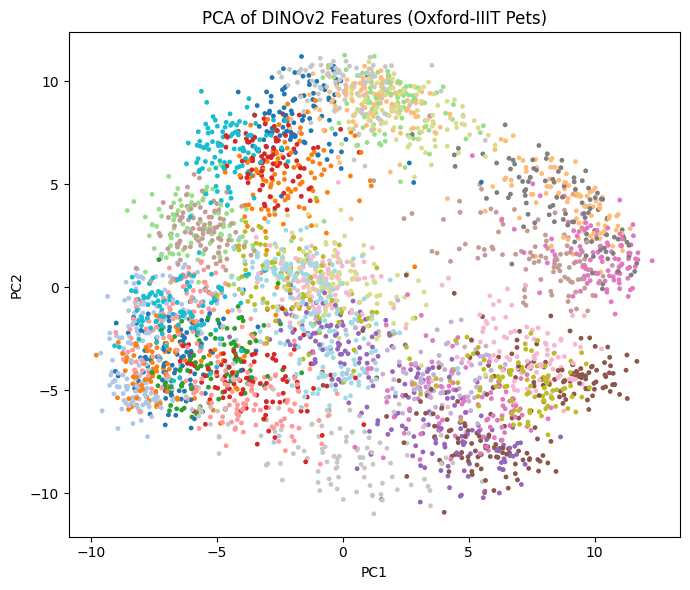

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap="tab20", s=6)
plt.title("PCA of DINOv2 Features (Oxford-IIIT Pets)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



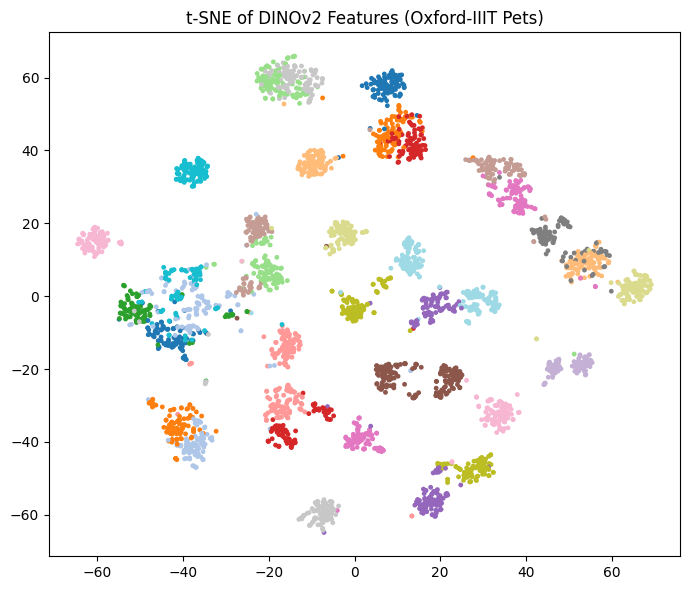

In [ ]:
pca_50 = PCA(n_components=50, random_state=42)
X_50 = pca_50.fit_transform(X_train_scaled)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=42
)

X_tsne = tsne.fit_transform(X_50)

plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="tab20", s=6)
plt.title("t-SNE of DINOv2 Features (Oxford-IIIT Pets)")
plt.tight_layout()
plt.show()



# Clustering and Classification Evaluation

Applies L2 normalisation followed by K-Means clustering to assess the structure of the DINOv2 feature space using the Davies–Bouldin Index, then trains a multinomial logistic regression classifier to evaluate multi-class classification performance and visualises the results using a confusion matrix.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

X_l2 = normalize(X_train, norm="l2")

k = len(np.unique(y_train))  # 37 classes
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_l2)

db = davies_bouldin_score(X_l2, clusters)
print("Davies–Bouldin Index:", db)


Davies–Bouldin Index: 2.3767227857312587


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

clf = LogisticRegression(
    max_iter=2000,
    multi_class="multinomial",
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9452166802943581
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        98
           1       0.78      0.90      0.83       100
           2       0.76      0.68      0.72       100
           3       1.00      0.96      0.98       100
           4       0.93      0.99      0.96       100
           5       0.83      0.95      0.89       100
           6       0.84      0.85      0.85       100
           7       0.97      1.00      0.98        88
           8       0.91      0.93      0.92        99
           9       0.97      0.88      0.92       100
          10       0.97      0.92      0.94       100
          11       0.94      0.87      0.90        97
          12       0.97      0.98      0.98       100
          13       0.99      0.96      0.97       100
          14       0.98      0.99      0.99       100
          15       0.99      0.99      0.99       100
          16       0.98      1.00      0.99       10

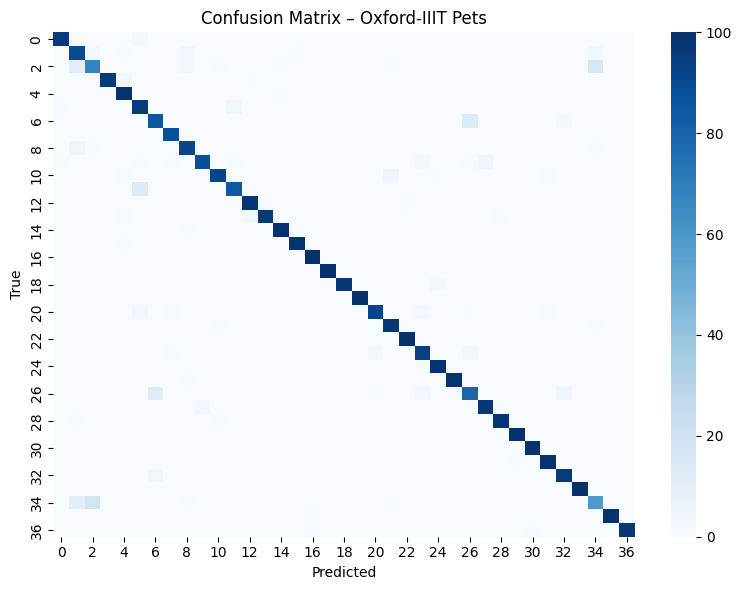

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix – Oxford-IIIT Pets")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# **Conclusion**

The results demonstrate that the pretrained DINOv2 features provide a strong and discriminative representation for the Oxford-IIIT Pets dataset. The logistic regression classifier achieves an overall accuracy of 94.5% across 37 classes, indicating that the extracted embeddings capture meaningful class-specific information even in a challenging multi-class setting.

The confusion matrix shows a clear diagonal dominance, confirming that most pet breeds are correctly classified, while misclassifications are limited to a small number of visually similar classes. Variations in precision and recall across classes highlight the inherent difficulty of fine-grained breed recognition, yet performance remains consistently high for the majority of categories.

Overall, these results validate the effectiveness of using frozen DINOv2 embeddings combined with a simple linear classifier for multi-class image classification, demonstrating strong generalisation without the need for end-to-end model fine-tuning.